In [62]:
import pandas as pd
import numpy as np
import re
from konlpy.tag import Okt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split

In [4]:
df = pd.read_csv('../df.csv')
df

,user_id,movie_id,review,rating
0,1,10001,전체관람가는 아닌것 같아요,10
1,2,10001,디렉터스컷으로봐서 거의 3시간짜리인데 참 흡인력있다,10
2,3,10001,태어나 처음으로 가슴아리는 영화였다. 20년이상 지났지만.. 생각하면 또 가슴이...,10
3,4,10001,어린시절 고딩때 봤던 때랑 또 결혼하고 나서 봤을때의 느낌은 확실히 다르네요. 뭔가...,10
4,5,10001,토토에게 넓은 세상을 보여주고픈 알프레도.. 그가 토토를 위해 정을 떼려고 했던 장...,10
...,...,...,...,...
712399,4031,99876,아직까지 여운이.... 우연히 봤다가 펑펑 울었네요. 음악때문에 감동이 백배!,10
712400,9870,99876,쓸쓸한 가을 감성을 채워주는 영화네요.. 사랑하고시프다...,9
712401,7078,99876,단언컨대 올 가을 최고의 영화!! 장담한다!!,10
712402,36911,99876,기대없이 봤다가 너무너무 반하게 된 영화! 가을 감성에 딱!,9


In [5]:
# 데이터프레임을 랜덤하게 섞음
df_shuffled = df.sample(frac=1, random_state=42)  

df_shuffled['rating'] = df_shuffled['rating'].astype(float)
df_shuffled['label'] = df_shuffled['rating'].apply(lambda x: 1 if x > 5 else 0)

# 긍정 리뷰와 부정 리뷰 분리
positive_reviews = df_shuffled[df_shuffled['label'] == 1]
negative_reviews = df_shuffled[df_shuffled['label'] == 0]
print(len(positive_reviews)) #560031
print(len(negative_reviews)) #152373

# 클래스 균형을 맞추기 위해 샘플 수 결정
num_samples = min(len(positive_reviews), len(negative_reviews))
print(num_samples) #152373

# 데이터를 샘플링하여 균형 잡힌 데이터셋 생성
positive_samples = positive_reviews.sample(num_samples, random_state=42)
negative_samples = negative_reviews.sample(num_samples, random_state=42)

balanced_df = pd.concat([positive_samples, negative_samples])
balanced_df = balanced_df.sample(frac=1, random_state = 42)

560031
152373
152373


In [8]:
balanced_df.reset_index(inplace= True, drop= True)

In [26]:
data = balanced_df[['review', 'rating', 'label']]
data

,review,rating,label
0,정말 최고네요. 신의 퀴즈 시즌2 화이팅 시즌3까지 갑시다.,10.0,1
1,완전 짜증?내 두시간이 너무 아깝다. 평점을 믿었던 내가 더 바보. 영화보다 짜증나...,1.0,0
2,갈등의 요소가 병콜라일 수 있다는. 에피소드가 재미난다,9.0,1
3,웃기면서 슬프다 ㅋㅋㅋㅋ,8.0,1
4,늦은밤 최고의 영화한편 그 감동이 아직도 ..,10.0,1
...,...,...,...
304741,기대안하고 봤는데 첫부분 30분은 지루하지만 중반부로 넘어가면서 몰입감있게 봄,10.0,1
304742,'우리'는 어쩌면 인생을 너무 심각하게 생각하는것일지도....,5.0,0
304743,새삼스러운 깨달음이 주는 유쾌함,10.0,1
304744,여러가지로 기억에 남는 영화. 독특하고 섬찟하고 여배우 예뻤음.,10.0,1


In [225]:
data_partial = data[:100000]
data_partial

,review,rating,label
0,정말 최고네요. 신의 퀴즈 시즌2 화이팅 시즌3까지 갑시다.,10.0,1
1,완전 짜증?내 두시간이 너무 아깝다. 평점을 믿었던 내가 더 바보. 영화보다 짜증나...,1.0,0
2,갈등의 요소가 병콜라일 수 있다는. 에피소드가 재미난다,9.0,1
3,웃기면서 슬프다 ㅋㅋㅋㅋ,8.0,1
4,늦은밤 최고의 영화한편 그 감동이 아직도 ..,10.0,1
...,...,...,...
99995,시즌투 안나오냨ㅋㅋㅋㅋㅋㅋㅋㅋ 강마에짱ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ,10.0,1
99996,진짜짜세임말이필없네,10.0,1
99997,모든게 평범 이상이었다,7.0,1
99998,"년도에 비해 잘만든 듯, 나름 재미, 엔딩 실망",8.0,1


In [226]:
data_partial.dropna(axis= 0, how= 'any', inplace= True)

C:\Users\USER\AppData\Local\Temp\ipykernel_38828\1726041175.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_partial.dropna(axis= 0, how= 'any', inplace= True)


In [215]:
def text_cleaning(text) :
  hangul = re.compile('[^ ㄱ-ㅣ가-힣]+')
  result = hangul.sub('', text)
  return result

In [227]:
data_partial['ko_review'] = data_partial['review'].apply(lambda x : text_cleaning(x))
del data_partial['review']
data_partial['ko_review'] = data_partial['ko_review'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
data_partial['ko_review'].replace('', np.nan, inplace=True)
print(data_partial.isnull().sum())
data_partial.head()

rating         0
label          0
ko_review    497
dtype: int64


C:\Users\USER\AppData\Local\Temp\ipykernel_38828\798741609.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_partial['ko_review'] = data_partial['review'].apply(lambda x : text_cleaning(x))
C:\Users\USER\AppData\Local\Temp\ipykernel_38828\798741609.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_partial['ko_review'] = data_partial['ko_review'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
C:\Users\USER\AppData\Local\Temp\ipykernel_38828\798741609.py:4: FutureWarning: A value is t

,rating,label,ko_review
0,10.0,1,정말 최고네요 신의 퀴즈 시즌 화이팅 시즌까지 갑시다
1,1.0,0,완전 짜증내 두시간이 너무 아깝다 평점을 믿었던 내가 더 바보 영화보다 짜증나는게 ...
2,9.0,1,갈등의 요소가 병콜라일 수 있다는 에피소드가 재미난다
3,8.0,1,웃기면서 슬프다 ㅋㅋㅋㅋ
4,10.0,1,늦은밤 최고의 영화한편 그 감동이 아직도


In [251]:
data_partial.loc[data_partial.ko_review.isnull()][:5]
data_partial.dropna(axis= 0, how= 'any', inplace= True)
data_partial.reset_index(drop= True, inplace= True)

C:\Users\USER\AppData\Local\Temp\ipykernel_38828\1475920920.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_partial.dropna(axis= 0, how= 'any', inplace= True)


##### 형태소 분석 - okt

In [51]:
stopwords = [
    '이', '그', '저', '의', '가', '에', '들', '을', '를', '은', '는', 
    '나', '다', '으로', '도', '에서', '한', '하다'
]

In [218]:
def get_pos(x) :
  tagger = Okt()
  pos = tagger.pos(x)
  words = [word for word, tag in pos if tag not in ['Josa', 'Suffix'] and word not in stopwords]
  return words

In [231]:
result = get_pos(data_partial['ko_review'][0])
print(type(result))
print(result[0])

<class 'list'>
정말


##### Count / tfidf vectorizer

In [232]:
# 피처 벡터화 - 18분 59초 10만 데이터
# 형태소를 벡터 형태의 학습 데이터셋(X데이터)으로 변환
index_vectorizer = CountVectorizer(tokenizer = lambda x : get_pos(x))
X = index_vectorizer.fit_transform(data_partial['ko_review'].tolist())

X.shape # 29850, 40345 : 단어개수

c:\Users\USER\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(99500, 79988)

In [233]:
print(data_partial['ko_review'][0])
print(X[0])

정말 최고네요 신의 퀴즈 시즌 화이팅 시즌까지 갑시다
  (0, 61772)	1
  (0, 69143)	1
  (0, 42613)	1
  (0, 70841)	1
  (0, 42040)	2
  (0, 78471)	1
  (0, 1928)	1


In [234]:
# CounterVectorizer를 이용해서 만든 피처 벡터를 tfidf 기반으로 변경

tfidf_vectorizer = TfidfTransformer()
X = tfidf_vectorizer.fit_transform(X) # countervectorizer의 피쳐 벡터

print(X.shape)
print(X[0]) #가중치 반영


(99500, 79988)
  (0, 78471)	0.3162613079777029
  (0, 70841)	0.42494267077411174
  (0, 69143)	0.1924500417668173
  (0, 61772)	0.16707176962215323
  (0, 42613)	0.3451234404812952
  (0, 42040)	0.5924679290125866
  (0, 1928)	0.42932980419807865


In [235]:
# 훈련 데이터와 검증 데이터 생성
y = data_partial['label']
x_train, x_test, y_train, y_test = train_test_split(X , y, test_size= 0.3)
print(x_train.shape)
print(x_test.shape)

(69650, 79988)
(29850, 79988)


로지스틱 회귀

In [236]:
from sklearn.linear_model import LogisticRegression #0.79 - 데이터 10만개
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 로지스틱 회귀 학습
lr = LogisticRegression(random_state= 42)
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
y_pred_probability = lr.predict_proba(x_test)[:, 1]

# 로지스틱 회귀 성능 평가
print('accuracy : %.2f'%accuracy_score(y_test, y_pred))
print('precision : %.3f'%precision_score(y_test, y_pred))
print('recall : %.3f'%recall_score(y_test, y_pred))
print('F1 : %.3f'%f1_score(y_test, y_pred))


accuracy : 0.79
precision : 0.793
recall : 0.782
F1 : 0.787


다중 로지스틱 회귀 - keras

In [237]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [255]:
X = data_partial[['ko_review']]
X.reset_index(inplace= True, drop= True)
X['ko_review'] = X['ko_review'].apply(get_pos) #10만개 32m 52.3s
y = data_partial[['label']]


C:\Users\USER\AppData\Local\Temp\ipykernel_38828\2046576690.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['ko_review'] = X['ko_review'].apply(get_pos) #19m 26.7s


In [256]:
y.reset_index(inplace = True, drop = True)

In [257]:
print(len(X))
print(len(y)) # 99500

99500
99500


In [258]:
drop_train = [index for index, sentence in enumerate(X['ko_review']) if len(sentence) < 1]
len(drop_train) #308

308

In [259]:
X.drop(index= drop_train, axis= 0, inplace= True)
y.drop(index= drop_train, axis= 0, inplace= True)

print(len(X)) #99192
print(len(y))

99192
99192


C:\Users\USER\AppData\Local\Temp\ipykernel_38828\1745464854.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(index= drop_train, axis= 0, inplace= True)
C:\Users\USER\AppData\Local\Temp\ipykernel_38828\1745464854.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y.drop(index= drop_train, axis= 0, inplace= True)


In [288]:
x_train, x_test, y_train, y_test = train_test_split(X['ko_review'] , y, test_size= 0.2)

In [289]:
# 정수 인코딩
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train) # 단어 사전 생성
print(tokenizer.word_index)
X_train = tokenizer.texts_to_sequences(x_train)
X_test = tokenizer.texts_to_sequences(x_test) # 정수 인코딩
y_train = np.array(y_train['label'])
y_test = np.array(y_test['label'])

{'영화': 1, '너무': 2, '정말': 3, '점': 4, '진짜': 5, '것': 6, '연기': 7, '그': 8, '스토리': 9, '못': 10, '평점': 11, '생각': 12, '안': 13, '내': 14, '다': 15, '하는': 16, '이런': 17, '왜': 18, '그냥': 19, '더': 20, '사람': 21, '배우': 22, '볼': 23, '드라마': 24, '최고': 25, '재미': 26, '말': 27, '감독': 28, '보고': 29, '내용': 30, '때': 31, '감동': 32, 'ㅋㅋ': 33, '거': 34, '뭐': 35, '본': 36, '시간': 37, '없는': 38, '수': 39, '작품': 40, '없다': 41, '사랑': 42, '액션': 43, '할': 44, '쓰레기': 45, '봤는데': 46, '나': 47, '마지막': 48, '하나': 49, '정도': 50, '같은': 51, '장면': 52, '있는': 53, '별로': 54, '느낌': 55, '좋은': 56, '주인공': 57, '저': 58, '아': 59, '이야기': 60, '다시': 61, '이건': 62, '듯': 63, '연출': 64, 'ㅋ': 65, '처음': 66, 'ㅠㅠ': 67, '보는': 68, '많이': 69, 'ㅋㅋㅋ': 70, '이렇게': 71, '걸': 72, '끝': 73, '때문': 74, '지금': 75, '그리고': 76, '완전': 77, '참': 78, '소재': 79, '돈': 80, '입니다': 81, '이해': 82, '결말': 83, '임': 84, '기': 85, '보면': 86, '없고': 87, 'ㅡㅡ': 88, '최악': 89, '역시': 90, '편': 91, '여자': 92, '봐도': 93, '하지만': 94, '년': 95, '해서': 96, '함': 97, '재밌게': 98, '별': 99, '된': 100, '같다': 101, '일': 102, '전개': 

In [290]:
vocab_size = len(tokenizer.word_index) + 1
vocab_size #70627

70627

리뷰의 최대 길이 : 51
리뷰의 평균 길이 : 9.84049752372311


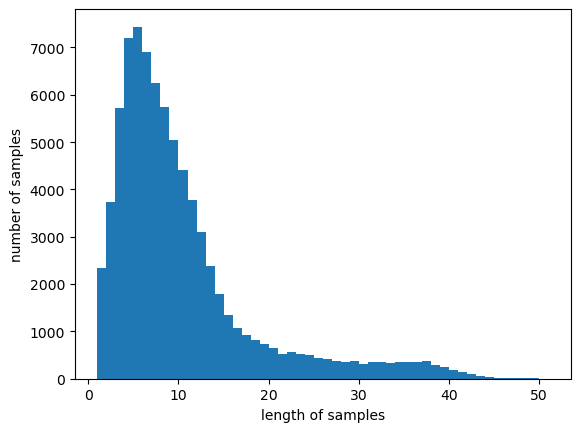

In [291]:
# 패딩
import matplotlib.pyplot as plt

print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [292]:
review_lengths = [len(review) for review in X_train]
# 95% 이상을 차지하는 리뷰 길이 계산
sorted_lengths = sorted(review_lengths)
percentile_99_length = np.percentile(sorted_lengths, 99)
print('99% 이상을 차지하는 리뷰의 길이:', percentile_99_length)

max_len = int(percentile_99_length)

X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

99% 이상을 차지하는 리뷰의 길이: 39.0


In [293]:
print(len(X_test))
print(len(y_test))

19839
19839


다중 로지스틱 회귀

은닉층 없는 모델

In [294]:
from sklearn.model_selection import ParameterGrid
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import SGD, Adam

# 하이퍼파라미터 그리드 설정
param_grid = {
    'learning_rate': [0.001, 0.01, 0.1],
    'batch_size': [32, 64, 128],
    'epochs': [20, 30, 40]
}

input_dim = X_train.shape[1]
best_accuracy = 0
best_params = None

# 파라미터 그리드 생성
grid = ParameterGrid(param_grid)

for params in grid:
    learning_rate = params['learning_rate']
    batch_size = params['batch_size']
    epochs = params['epochs']
    
    optimizer = SGD(learning_rate=learning_rate)
    
    # 모델 구성
    model = Sequential()
    model.add(Input(shape = (max_len, )))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])
    
    # 모델 학습
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split = 0.2, verbose=0)
    
    val_accuracy = max(history.history['val_binary_accuracy'])
    
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_params = params

print('Best Accuracy:', best_accuracy)
print('Best Parameters:', best_params)

Best Accuracy: 0.5176107287406921
Best Parameters: {'batch_size': 32, 'epochs': 40, 'learning_rate': 0.001}


In [ ]:
# 51.05%
# batch_size = 32, epochs = 40, learning_rate = 0.001

In [ ]:
# 73.25% 10.1s - sgd
# 75% 1m 28.6s (earlystopping 없이)

In [295]:
print(model.predict(X_test))
print(model.evaluate(X_test, y_test)[1]) #65%

620/620 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
620/620 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step - binary_accuracy: 0.4958 - loss: 1802323.6250
0.49790817499160767


LSTM - tokenizer

In [242]:
import pickle
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

LSTM

In [296]:
# 69.885 1m 3.4s - adam
# 68.492 45.1s - rmsprop
# 100,000 79.009% 9m 37.5s - rmsprop
# 100,000 78.555% 8m 21.9s - adam

from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import ParameterGrid
from tensorflow.keras.optimizers import Adam, RMSprop

# 하이퍼파라미터 그리드 설정
param_grid = {
    'embedding_dim': [50, 100, 200],
    'hidden_units': [64, 128, 256],
    'dropout_ratio': [0.3, 0.5, 0.7],
    'learning_rate': [0.1, 0.01, 0.001],
    'batch_size': [32, 64, 128],
    'optimizer': ['adam', 'rmsprop']
}

best_accuracy = 0
best_params = None

for params in ParameterGrid(param_grid):
    embedding_dim = params['embedding_dim']
    hidden_units = params['hidden_units']
    dropout_ratio = params['dropout_ratio']
    learning_rate = params['learning_rate']
    batch_size = params['batch_size']
    optimizer_choice = params['optimizer']
    
    if optimizer_choice == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_choice == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim))
    model.add(LSTM(hidden_units))
    model.add(Dropout(dropout_ratio))
    model.add(Dense(1, activation='sigmoid'))
    
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
    mc = ModelCheckpoint('best_model_lstm.keras', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
    
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])
    
    history = model.fit(X_train, y_train, epochs=30, callbacks=[es, mc], batch_size=batch_size, validation_split=0.2, verbose=0)
    
    val_accuracy = max(history.history['val_acc'])
    
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_params = params

print('Best Accuracy:', best_accuracy)
print('Best Parameters:', best_params)


Epoch 1: val_acc improved from -inf to 0.52889, saving model to best_model_lstm.keras

Epoch 2: val_acc did not improve from 0.52889

Epoch 3: val_acc improved from 0.52889 to 0.53966, saving model to best_model_lstm.keras

Epoch 4: val_acc improved from 0.53966 to 0.54174, saving model to best_model_lstm.keras

Epoch 5: val_acc improved from 0.54174 to 0.54924, saving model to best_model_lstm.keras

Epoch 6: val_acc did not improve from 0.54924

Epoch 7: val_acc improved from 0.54924 to 0.55838, saving model to best_model_lstm.keras

Epoch 8: val_acc did not improve from 0.55838

Epoch 9: val_acc improved from 0.55838 to 0.56323, saving model to best_model_lstm.keras
Epoch 9: early stopping

Epoch 1: val_acc improved from -inf to 0.56058, saving model to best_model_lstm.keras

Epoch 2: val_acc improved from 0.56058 to 0.58894, saving model to best_model_lstm.keras

Epoch 3: val_acc improved from 0.58894 to 0.61105, saving model to best_model_lstm.keras

Epoch 4: val_acc improved from

In [277]:
print(model.predict(X_test))
print(model.evaluate(X_test, y_test)[1]) #75.31%

930/930 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step
[[0.99745053]
 [0.95599234]
 [0.7124901 ]
 ...
 [0.37077057]
 [0.8110219 ]
 [0.99809396]]
930/930 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - acc: 0.7531 - loss: 0.9437
0.7572081685066223


CNN

In [211]:
#70.814 - adam

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

embedding_dim = 100 # 임베딩 벡터의 차원
dropout_ratio = 0.5 # 드롭아웃 비율
num_filters = 128  # 커널의 수
kernel_size = 3 # 커널의 크기
hidden_units = 128 # 뉴런의 수

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(Dropout(dropout_ratio))
model.add(Conv1D(num_filters, kernel_size, padding='valid', activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(hidden_units, activation='relu'))
model.add(Dropout(dropout_ratio))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint('best_model_CNN.keras', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), callbacks=[es, mc])

Epoch 1/20
324/326 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - acc: 0.5194 - loss: 0.6918
Epoch 1: val_acc improved from -inf to 0.67765, saving model to best_model_CNN.keras
326/326 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - acc: 0.5197 - loss: 0.6918 - val_acc: 0.6777 - val_loss: 0.6235
Epoch 2/20
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - acc: 0.6949 - loss: 0.5922
Epoch 2: val_acc improved from 0.67765 to 0.70231, saving model to best_model_CNN.keras
326/326 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - acc: 0.6949 - loss: 0.5922 - val_acc: 0.7023 - val_loss: 0.5708
Epoch 3/20
325/326 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - acc: 0.7582 - loss: 0.5259
Epoch 3: val_acc improved from 0.70231 to 0.70948, saving model to best_model_CNN.keras
326/326 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - acc: 0.7582 - loss: 0.5259 - val_acc: 0.7095 - val_loss: 0.5720
Epoch 4/20
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - acc: 0.7869 - loss: 0.4771
Epoch 4: val_acc did not improve from 0.70948
326/326 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step

Multi-Kernel 1D CNN

###### 하이퍼 파라미터 - embedding_dim = 128, Dropout = 0.5, 0.8

In [198]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense, Input, Flatten, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

embedding_dim = 128
dropout_ratio = (0.5, 0.8)
num_filters = 128
hidden_units = 128

In [ ]:
model_input = Input(shape = (max_len,))
z = Embedding(vocab_size, embedding_dim, input_length = max_len, name="embedding")(model_input)
z = Dropout(dropout_ratio[0])(z)

In [200]:
conv_blocks = []

for sz in [3, 4, 5]:
    conv = Conv1D(filters = num_filters,
                         kernel_size = sz,
                         padding = "valid",
                         activation = "relu",
                         strides = 1)(inputs)
    conv = GlobalMaxPooling1D()(conv)
    conv_blocks.append(conv)

In [209]:
z = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]
z = Dropout(dropout_ratio[1])(z)
z = Dense(hidden_units, activation="relu")(z)
model_output = Dense(1, activation="sigmoid")(z)

model = Model(model_input, model_output)
model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["acc"])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('CNN_model.keras', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.fit(X_train, y_train, batch_size=64, epochs=10, validation_split=0.2, verbose=2, callbacks=[es, mc])

#69.83% 37초 - adam
#69.308 26.8s - rmsprop

Epoch 1/10

Epoch 1: val_acc improved from -inf to 0.69308, saving model to CNN_model.keras
131/131 - 8s - 64ms/step - acc: 0.9587 - loss: 0.1368 - val_acc: 0.6931 - val_loss: 1.1731
Epoch 2/10

Epoch 2: val_acc did not improve from 0.69308
131/131 - 5s - 40ms/step - acc: 0.9663 - loss: 0.0906 - val_acc: 0.6907 - val_loss: 1.3078
Epoch 3/10

Epoch 3: val_acc did not improve from 0.69308
131/131 - 5s - 35ms/step - acc: 0.9705 - loss: 0.0827 - val_acc: 0.6902 - val_loss: 1.3620
Epoch 4/10

Epoch 4: val_acc did not improve from 0.69308
131/131 - 4s - 33ms/step - acc: 0.9730 - loss: 0.0789 - val_acc: 0.6873 - val_loss: 1.3413
Epoch 5/10

Epoch 5: val_acc did not improve from 0.69308
131/131 - 4s - 32ms/step - acc: 0.9767 - loss: 0.0682 - val_acc: 0.6820 - val_loss: 1.4966
Epoch 5: early stopping


In [203]:
loaded_model = load_model('CNN_model.keras')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.6934 - loss: 0.5807

 테스트 정확도: 0.6951


GRU

In [208]:
#68.35% 36.3s - adam
#68.924% 40.9s - rmsprop

from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(GRU(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.keras', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - acc: 0.5404 - loss: 0.6886
Epoch 1: val_acc improved from -inf to 0.61287, saving model to best_model.keras
131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - acc: 0.5407 - loss: 0.6885 - val_acc: 0.6129 - val_loss: 0.6645
Epoch 2/15
130/131 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - acc: 0.7187 - loss: 0.5814
Epoch 2: val_acc improved from 0.61287 to 0.67051, saving model to best_model.keras
131/131 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - acc: 0.7187 - loss: 0.5811 - val_acc: 0.6705 - val_loss: 0.6091
Epoch 3/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - acc: 0.7999 - loss: 0.4521
Epoch 3: val_acc improved from 0.67051 to 0.68924, saving model to best_model.keras
131/131 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - acc: 0.7999 - loss: 0.4522 - val_acc: 0.6892 - val_loss: 0.6188
Epoch 4/15
130/131 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - acc: 0.8545 - loss: 0.3636
Epoch 4: val_acc did not improve from 0.68924
131/131 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - acc: 0.85

BiLSTM

In [207]:
#68.156% 49.2s - adam
#69.645 1m 24.5s - rmsprop
import re
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(Bidirectional(LSTM(hidden_units))) # Bidirectional LSTM을 사용
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model_BiLSTM.keras', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=256, validation_split=0.2)

Epoch 1/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - acc: 0.4964 - loss: 0.6933
Epoch 1: val_acc improved from -inf to 0.50432, saving model to best_model_BiLSTM.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 252ms/step - acc: 0.4966 - loss: 0.6933 - val_acc: 0.5043 - val_loss: 0.6937
Epoch 2/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - acc: 0.5167 - loss: 0.6930
Epoch 2: val_acc improved from 0.50432 to 0.54179, saving model to best_model_BiLSTM.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 198ms/step - acc: 0.5171 - loss: 0.6930 - val_acc: 0.5418 - val_loss: 0.6904
Epoch 3/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - acc: 0.5643 - loss: 0.6892
Epoch 3: val_acc improved from 0.54179 to 0.61287, saving model to best_model_BiLSTM.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 192ms/step - acc: 0.5646 - loss: 0.6891 - val_acc: 0.6129 - val_loss: 0.6831
Epoch 4/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - acc: 0.6207 - loss: 0.6777
Epoch 4: val_acc did not improve from 0.61287
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 202ms/st